In [9]:
pip install numpy pandas scikit-learn matplotlib tensorflow

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [11]:
# Step 1: Load and preprocess the dataset
data = pd.read_excel('dataset.xlsx', skiprows=1)
data.fillna(0, inplace=True)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1, 1)

# Normalize the features
scaler_X = MinMaxScaler()
# X_normalized = scaler_X.fit_transform(X)
X_normalized = scaler_X.fit_transform(data.iloc[:, :-1].values)


# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, data.iloc[:, -1].values.reshape(-1, 1), test_size=0.2, random_state=42)


In [12]:
# # Step 2: Define the ANN architecture
# def build_ann(input_dim):
#     model = Sequential([
#         Dense(64, activation='relu', input_dim=input_dim),
#         Dense(32, activation='relu'),
#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model


# Step 2: Define the ANN architecture
def build_ann(input_dim):
    model = Sequential([
        Dense(32, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# def build_ann(input_dim):
#     model = Sequential([
#         Dense(32, activation='relu', input_dim=input_dim),
#         Dense(32, activation='relu'),
#         Dense(32, activation='relu'),
#         Dense(16, activation='relu'),
#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

In [13]:
# Step 3: Define the objective function for GWO
def gwo_ann_objective_function(params):
    model = build_ann(X_train.shape[1])
    weights_shapes = [w.shape for w in model.get_weights()]
    start = 0
    weights = []
    for shape in weights_shapes:
        size = np.prod(shape)
        weight = np.array(params[start:start + size]).reshape(shape)
        weights.append(weight)
        start += size
    model.set_weights(weights)
    model.fit(X_train, y_train, epochs=50, verbose=0)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [14]:
# Step 4: Implement Grey Wolf Optimizer
class GWO:
    def __init__(self, objective_function, dim, population_size, iterations):
        self.objective_function = objective_function
        self.dim = dim
        self.population_size = population_size
        self.iterations = iterations

    def optimize(self):
        alpha_pos = np.zeros(self.dim)
        beta_pos = np.zeros(self.dim)
        delta_pos = np.zeros(self.dim)
        alpha_score = float('inf')
        beta_score = float('inf')
        delta_score = float('inf')
        positions = np.random.uniform(-1, 1, (self.population_size, self.dim))

        for t in range(self.iterations):
            for i in range(self.population_size):
                # Boundary checking
                positions[i, :] = np.clip(positions[i, :], -1, 1)

                fitness = self.objective_function(positions[i, :])

                if fitness < alpha_score:
                    alpha_score = fitness
                    alpha_pos = positions[i, :].copy()
                elif fitness < beta_score:
                    beta_score = fitness
                    beta_pos = positions[i, :].copy()
                elif fitness < delta_score:
                    delta_score = fitness
                    delta_pos = positions[i, :].copy()

            a = 2 - 2 * t / self.iterations  # linearly decreases from 2 to 0

            for i in range(self.population_size):
                r1 = np.random.random(self.dim)
                r2 = np.random.random(self.dim)
                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = np.abs(C1 * alpha_pos - positions[i, :])
                X1 = alpha_pos - A1 * D_alpha

                r1 = np.random.random(self.dim)
                r2 = np.random.random(self.dim)
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_beta = np.abs(C2 * beta_pos - positions[i, :])
                X2 = beta_pos - A2 * D_beta

                r1 = np.random.random(self.dim)
                r2 = np.random.random(self.dim)
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_delta = np.abs(C3 * delta_pos - positions[i, :])
                X3 = delta_pos - A3 * D_delta

                positions[i, :] = (X1 + X2 + X3) / 3

        return alpha_pos


In [15]:
# Step 5: Train the hybrid model using GWO
gwo = GWO(gwo_ann_objective_function, dim=sum([np.prod(w.shape) for w in build_ann(X_train.shape[1]).get_weights()]), population_size=10, iterations=20)
best_weights = gwo.optimize()

# Set the best weights found by GWO to the ANN
best_model = build_ann(X_train.shape[1])
weights_shapes = [w.shape for w in best_model.get_weights()]
start = 0
weights = []
for shape in weights_shapes:
    size = np.prod(shape)
    weight = np.array(best_weights[start:start + size]).reshape(shape)
    weights.append(weight)
    start += size
best_model.set_weights(weights)

# Train the ANN with the best weights
best_model.fit(X_train, y_train, epochs=10, verbose=0)

2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step - loss: 5.8182e-04
Test Loss: 0.0005818157223984599
2/2 [==============================] - 0s 6ms/step
R-squared (Test): 0.9891605360390813
6/6 [==============================] - 0s 3ms/step
R-squared (Train): 0.9626193550029651
Train RMSE: 0.03809072130486361
Test RMSE: 0.024120860645840472


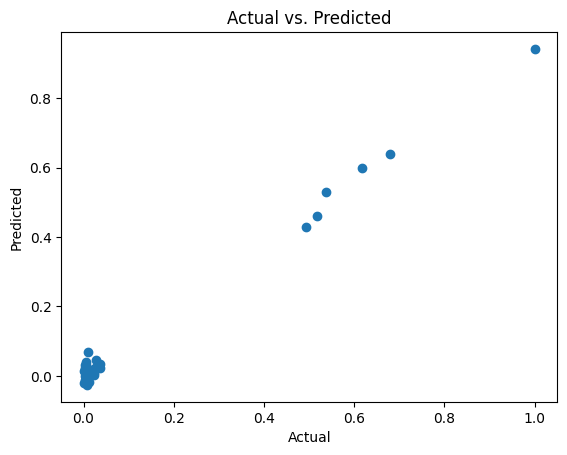

In [16]:
# Step 6: Evaluate the model
loss = best_model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Calculate R-squared for the test set
y_pred_test = best_model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
print("R-squared (Test):", r2_test)

# Calculate R-squared for the training set
y_pred_train = best_model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
print("R-squared (Train):", r2_train)

# Calculate RMSE for both training and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

# Optional: Plot predictions vs. actual
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()